# Radiomics Machine Learning Analysis for Classsificaiton of Cirrhotic Liver 

### Workflow
- Input data 
    - NifTI images 
- Preprocessing if needed
- Feature extraction 
    - PyRadiomics
- Model development
    - Neural network?
    - Random forest?

*Note*
- I had to create a virtual environment using conda in order to install pyradiomics which I believe only works on specific versions of python*
- I also had to downgrade numpy to use pyradiomics

In [1]:
from radiomics import featureextractor, getTestCase
import os
import SimpleITK
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

import matplotlib
import matplotlib.pyplot as plt

### Some initial handling of dataset/ pathing

In [2]:
# Directories
#T1
train_images_T1 = os.path.join("Cirrhosis_T1_3D", "train_images")
train_masks_T1 = os.path.join("Cirrhosis_T1_3D", "train_masks")
valid_images_T1 = os.path.join("Cirrhosis_T1_3D", "valid_images")
valid_masks_T1 = os.path.join("Cirrhosis_T1_3D", "valid_masks")
test_images_T1 = os.path.join("Cirrhosis_T1_3D", "test_images")
test_masks_T1 = os.path.join("Cirrhosis_T1_3D", "test_masks")

#T2
train_images_T2 = os.path.join("Cirrhosis_T2_3D", "train_images")
train_masks_T2 = os.path.join("Cirrhosis_T2_3D", "train_masks")
valid_images_T2 = os.path.join("Cirrhosis_T2_3D", "valid_images")
valid_masks_T2 = os.path.join("Cirrhosis_T2_3D", "valid_masks")
test_images_T2 = os.path.join("Cirrhosis_T2_3D", "test_images")
test_masks_T2 = os.path.join("Cirrhosis_T2_3D", "test_masks")

# Quick check
print("T1 Train Images:", os.listdir(train_images_T1))
print("T1 Train Masks:", os.listdir(train_masks_T1))
print("T1 Valid Images:", os.listdir(valid_images_T1))
print("T1 Valid Masks:", os.listdir(valid_masks_T1))
print("T1 Test Images:", os.listdir(test_images_T1))
print("T1 Test Masks:", os.listdir(test_masks_T1))

T1 Train Images: ['427.nii.gz', '376.nii.gz', '268.nii.gz', '439.nii.gz', '319.nii.gz', '448.nii.gz', '307.nii.gz', '207.nii.gz', '403.nii.gz', '352.nii.gz', '252.nii.gz', '198.nii.gz', '186.nii.gz', '340.nii.gz', '411.nii.gz', '323.nii.gz', '143.nii.gz', '289.nii.gz', '389.nii.gz', '297.nii.gz', '120.nii.gz', '397.nii.gz', '10.nii.gz', '26.nii.gz', '179.nii.gz', '38.nii.gz', '175.nii.gz', '108.nii.gz', '130.nii.gz', '287.nii.gz', '153.nii.gz', '12.nii.gz', '399.nii.gz', '299.nii.gz', '295.nii.gz', '.DS_Store', '141.nii.gz', '28.nii.gz', '169.nii.gz', '114.nii.gz', '177.nii.gz', '106.nii.gz', '165.nii.gz', '24.nii.gz', '118.nii.gz', '378.nii.gz', '278.nii.gz', '366.nii.gz', '437.nii.gz', '446.nii.gz', '317.nii.gz', '274.nii.gz', '425.nii.gz', '374.nii.gz', '209.nii.gz', '458.nii.gz', '309.nii.gz', '196.nii.gz', '342.nii.gz', '184.nii.gz', '250.nii.gz', '102.nii.gz', '43.nii.gz', '161.nii.gz', '20.nii.gz', '291.nii.gz', '126.nii.gz', '391.nii.gz', '383.nii.gz', '283.nii.gz', '149.nii.gz

In [4]:
#Need to pair the images with the masks to be used in the feature extractor
def pair(image_dir, mask_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.nii.gz')]
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.nii.gz')]
    
    image_mask_pairs = {}
    
    for image_file in image_files:
        if image_file in mask_files:
            image_mask_pairs[image_file] = image_file  # Both the image and mask have the same name
    
    return image_mask_pairs

train_pairs_T1 = pair(train_images_T1, train_masks_T1)
valid_pairs_T1 = pair(valid_images_T1, valid_masks_T1)
test_pairs_T1 = pair(test_images_T1, test_masks_T1)

train_pairs_T2 = pair(train_images_T2, train_masks_T2)
valid_pairs_T2 = pair(valid_images_T2, valid_masks_T2)
test_pairs_T2 = pair(test_images_T2, test_masks_T2)

# Verify pairs
print("T1 Train Pairs:", train_pairs_T1)
print("T1 Valid Pairs:", valid_pairs_T1)
print("T1 Test Pairs:", test_pairs_T1)
len(train_pairs_T1)
len(valid_pairs_T1)
len(test_pairs_T1)


T1 Train Pairs: {'427.nii.gz': '427.nii.gz', '376.nii.gz': '376.nii.gz', '268.nii.gz': '268.nii.gz', '439.nii.gz': '439.nii.gz', '319.nii.gz': '319.nii.gz', '448.nii.gz': '448.nii.gz', '307.nii.gz': '307.nii.gz', '207.nii.gz': '207.nii.gz', '403.nii.gz': '403.nii.gz', '352.nii.gz': '352.nii.gz', '252.nii.gz': '252.nii.gz', '198.nii.gz': '198.nii.gz', '186.nii.gz': '186.nii.gz', '340.nii.gz': '340.nii.gz', '411.nii.gz': '411.nii.gz', '323.nii.gz': '323.nii.gz', '143.nii.gz': '143.nii.gz', '289.nii.gz': '289.nii.gz', '389.nii.gz': '389.nii.gz', '297.nii.gz': '297.nii.gz', '120.nii.gz': '120.nii.gz', '397.nii.gz': '397.nii.gz', '10.nii.gz': '10.nii.gz', '26.nii.gz': '26.nii.gz', '179.nii.gz': '179.nii.gz', '38.nii.gz': '38.nii.gz', '175.nii.gz': '175.nii.gz', '108.nii.gz': '108.nii.gz', '130.nii.gz': '130.nii.gz', '287.nii.gz': '287.nii.gz', '153.nii.gz': '153.nii.gz', '12.nii.gz': '12.nii.gz', '399.nii.gz': '399.nii.gz', '299.nii.gz': '299.nii.gz', '295.nii.gz': '295.nii.gz', '141.nii.gz

31

### Trimming the dataset

In [5]:
#Read in the data 
df_train_T1 = pd.read_csv('train_features_T1.csv')
df_valid_T1 = pd.read_csv('valid_features_T1.csv')
df_test_T1 = pd.read_csv('test_features_T1.csv')

df_train_T2 = pd.read_csv('train_features_T2.csv')
df_valid_T2 = pd.read_csv('valid_features_T2.csv')
df_test_T2 = pd.read_csv('test_features_T2.csv')

def filter_features(df):
    shape_features = [col for col in df.columns if "shape" in col.lower()]
    return df[shape_features]

df_train_T1_shape = filter_features(df_train_T1) 
df_valid_T1_shape = filter_features(df_valid_T1)
df_test_T1_shape = filter_features(df_test_T1)

df_train_T2_shape = filter_features(df_train_T2)
df_valid_T2_shape = filter_features(df_valid_T2)
df_test_T2_shape = filter_features(df_test_T2)

print("T1 Train Shape Features:", df_train_T1_shape.shape[1])

#Appending the labels (making sure the patient IDs)
labels_file1 = pd.read_csv('Metadata/T1_age_gender_evaluation.csv')
labels_file2 = pd.read_csv('Metadata/T2_age_gender_evaluation.csv')

#Dictionary mapping of labels to patient IDs 
label_mapping1 = dict(zip(labels_file1['Patient ID'], labels_file1['Radiological Evaluation']))
label_mapping2 = dict(zip(labels_file2['Patient ID'], labels_file2['Radiological Evaluation']))

def add_labels_to_features(features_df, pairs_dict, label_mapping):
    patient_ids = [int(filename.split('.')[0]) for filename in pairs_dict.keys()]
    labels = [label_mapping.get(pid, None) for pid in patient_ids]
    missing_labels = [pid for pid, label in zip(patient_ids, labels) if label is None]
    if missing_labels:
        print(f"Warning: No labels found for Patient IDs: {missing_labels}")
    features_df = features_df.copy() 
    features_df["Label"] = labels

    return features_df

# Update T1 datasets
df_train_T1_shape = add_labels_to_features(df_train_T1_shape, train_pairs_T1, label_mapping1)
df_valid_T1_shape = add_labels_to_features(df_valid_T1_shape, valid_pairs_T1, label_mapping1)
df_test_T1_shape = add_labels_to_features(df_test_T1_shape, test_pairs_T1, label_mapping1)

# Update T2 datasets 
df_train_T2_shape = add_labels_to_features(df_train_T2_shape, train_pairs_T2, label_mapping2)
df_valid_T2_shape = add_labels_to_features(df_valid_T2_shape, valid_pairs_T2, label_mapping2)
df_test_T2_shape = add_labels_to_features(df_test_T2_shape, test_pairs_T2, label_mapping2)

df_train_T2_shape

T1 Train Shape Features: 14


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Label
0,0.691243,0.463028,111.508018,240.823301,304.977948,202.582423,242.450714,305.301986,2.455555e+06,166.467504,0.532603,165264.689496,0.067302,2.456444e+06,1
1,0.500755,0.395914,110.687366,279.574242,288.156134,165.096606,251.715705,292.037313,1.621881e+06,139.998113,0.458121,145719.105856,0.089846,1.622585e+06,1
2,0.821592,0.535661,95.005330,177.360925,212.728733,177.643533,203.300705,218.627759,1.372653e+06,145.718395,0.571672,104482.789408,0.076117,1.373522e+06,1
3,0.839491,0.492280,91.823661,186.527185,229.303831,192.220627,207.468583,244.018340,1.139796e+06,156.587845,0.413548,127597.672525,0.111948,1.141142e+06,2
4,0.614953,0.435423,83.368390,191.465205,203.024451,149.231700,191.972573,216.698260,9.636749e+05,117.742115,0.488491,96586.101568,0.100227,9.641439e+05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.781508,0.474635,89.119347,187.763915,219.282664,176.115650,201.905377,219.690803,1.255470e+06,146.738987,0.513672,109564.197918,0.087269,1.257206e+06,2
252,0.576449,0.439311,92.614604,210.817907,225.550567,168.903530,227.750549,237.461723,1.274812e+06,121.525676,0.529309,107416.855903,0.084261,1.276323e+06,1
253,0.764530,0.647144,116.532107,180.071361,182.711991,198.687510,209.264437,219.457407,1.713243e+06,137.669879,0.570119,121450.030476,0.070889,1.715417e+06,3
254,0.624160,0.478011,107.220054,224.304630,269.772155,183.169281,237.049841,269.812876,1.632357e+06,140.002074,0.510784,131257.272637,0.080410,1.633643e+06,1


# Feed Forward Neural Network

In [6]:
scaler = MinMaxScaler()

# Data loading
class CustomDatasets(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Return the feature and label for the given index
        data = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return data, label

In [6]:
def set_seed(seed):
    torch.manual_seed(seed)  
    np.random.seed(seed)     
    random.seed(seed)       

class FFNN_radiomics(nn.Module):
    def __init__(self):
        super(FFNN_radiomics, self).__init__()
        self.linear1 = nn.Linear(14, 38)
        self.relu1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(38, 38)
        self.relu2 = nn.LeakyReLU()           
        self.linear_out = nn.Linear(38, 3)  

    def forward(self, x):
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.linear_out(x)
        return x

def train(dataloader, model, loss_func, optimizer):
  model.train()
  train_loss = 0
  num_batches = len(dataloader)
  for batch, (X, y) in enumerate(dataloader):

    #Core network
    pred = model(X)
    loss = loss_func(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #if batch % 10 == 0:
      #loss = loss.item()
      #train_loss.append(loss)
  #return train_loss

    train_loss += loss.item()
    avg_train_loss = train_loss / num_batches
    print(f"Train Loss: {avg_train_loss:.6f}")
  return avg_train_loss

def validate(dataloader, model, loss_func):
  size = len(dataloader)
  num_batches = len(dataloader)
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_func(pred, y).item()
  test_loss /= num_batches
  print(f"Avg Loss: {test_loss:>8f}\n")
  return test_loss

def test(dataloader, model, loss_func):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in dataloader:
    
            pred = model(X)
            _, predicted = torch.max(pred, 1)  
            correct += (predicted == y).sum().item()
            total += y.size(0)
            
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy


In [7]:
#Seperating the labels
#T1
labels_T1_train = df_train_T1_shape.iloc[:, -1].to_numpy()
labels_T1_valid= df_valid_T1_shape.iloc[:,-1].to_numpy()
labels_T1_test = df_test_T1_shape.iloc[:,-1].to_numpy()
labels_T1_train -= 1 #data loader requires the labels to be 0,1,2 not 1,2,3
labels_T1_valid -= 1
labels_T1_test -= 1
#T2 
labels_T2_train= df_train_T2_shape.iloc[:,-1].to_numpy()
labels_T2_valid= df_valid_T2_shape.iloc[:,-1].to_numpy()
labels_T2_test = df_test_T2_shape.iloc[:,-1].to_numpy()
labels_T2_train -= 1
labels_T2_valid -= 1
labels_T2_test -= 1

T1_train = df_train_T1_shape.iloc[:,:-1].to_numpy()
T1_train = np.array(T1_train, dtype=np.float32)
T1_valid = df_valid_T1_shape.iloc[:,:-1].to_numpy()
T1_valid = np.array(T1_valid, dtype=np.float32)
T1_test = df_test_T1_shape.iloc[:,:-1].to_numpy()
T1_test = np.array(T1_test, dtype=np.float32)

T2_train = df_train_T2_shape.iloc[:,:-1].to_numpy()
T2_train = np.array(T2_train, dtype=np.float32)
T2_valid = df_valid_T2_shape.iloc[:,:-1].to_numpy()
T2_valid = np.array(T2_valid, dtype=np.float32)
T2_test = df_test_T2_shape.iloc[:,:-1].to_numpy()
T2_test = np.array(T2_test, dtype=np.float32)

### T1 Training/Testing

Train Loss: 19224.996094
Train Loss: 45470.908203
Avg Loss: 36943.140625

Train Loss: 19058.898438
Train Loss: 41154.273438
Avg Loss: 35124.835938

Train Loss: 18001.382812
Train Loss: 39568.498047
Avg Loss: 33305.238281

Train Loss: 17976.529297
Train Loss: 34857.910156
Avg Loss: 31484.984375

Train Loss: 17214.201172
Train Loss: 32386.326172
Avg Loss: 29639.453125

Train Loss: 16175.138672
Train Loss: 30664.533203
Avg Loss: 27786.121094

Train Loss: 14496.955078
Train Loss: 30870.787109
Avg Loss: 25918.847656

Train Loss: 13460.181641
Train Loss: 29095.345703
Avg Loss: 24032.695312

Train Loss: 13161.266602
Train Loss: 25117.649414
Avg Loss: 22147.931641

Train Loss: 11190.752930
Train Loss: 26122.799805
Avg Loss: 20276.068359

Train Loss: 11581.039062
Train Loss: 19977.286133
Avg Loss: 18406.933594

Train Loss: 9930.037109
Train Loss: 20024.852539
Avg Loss: 16542.492188

Train Loss: 8598.193359
Train Loss: 19115.680664
Avg Loss: 14660.865234

Train Loss: 7943.014160
Train Loss: 1619

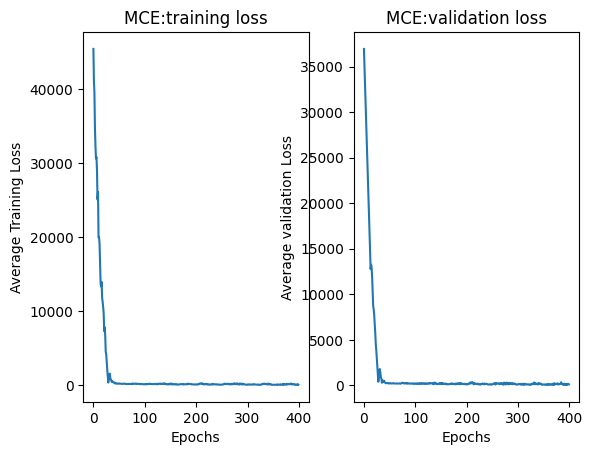

Test Accuracy: 0.5484
Final Test Accuracy: 0.5484


In [13]:
# Create instances of the data
train1 = CustomDatasets(T1_train,labels_T1_train)
valid1 = CustomDatasets(T1_valid, labels_T1_valid)
test1 = CustomDatasets(T1_test, labels_T1_test)

train_loader = DataLoader(train1, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid1, batch_size=200, shuffle=False)
test_loader = DataLoader(test1, batch_size=200, shuffle=False)

set_seed(20)
ff= FFNN_radiomics()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ff.parameters(), lr=1e-4)
epochs = 400
train_loss = []
validation_loss = []
for t in range(epochs):
  losses = train(train_loader, ff, loss_func, optimizer)
  train_loss.append(losses)
  validation_loss.append(validate(valid_loader, ff, loss_func))

# plot the learning curve
epoch_tr_loss = [torch.tensor(epoch_losses).mean().item() for epoch_losses in train_loss]
epoch_va_loss = [torch.tensor(epoch_losses).mean().item() for epoch_losses in validation_loss]
x=range(epochs)
plt.subplot(1,2,1)
plt.plot(x, epoch_tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.title('MCE:training loss')

plt.subplot(1,2,2)
plt.plot(x, epoch_va_loss)
plt.xlabel('Epochs')
plt.ylabel('Average validation Loss')
plt.title ('MCE:validation loss')
plt.show()

# final test accuracy
final_accuracy = test(test_loader, ff, loss_func)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

### T2 Training/Testing

Train Loss: 32447.009766
Train Loss: 44243.510742
Avg Loss: 48727.621094

Train Loss: 23984.257812
Train Loss: 39915.017578
Avg Loss: 25072.888672

Train Loss: 11979.120117
Train Loss: 27461.098633
Avg Loss: 29637.003906

Train Loss: 14953.437500
Train Loss: 28277.352539
Avg Loss: 9957.913086

Train Loss: 5385.403809
Train Loss: 11621.654297
Avg Loss: 14884.189453

Train Loss: 6923.379883
Train Loss: 11062.511230
Avg Loss: 13100.456055

Train Loss: 6033.613770
Train Loss: 12507.322266
Avg Loss: 16996.998047

Train Loss: 8017.990234
Train Loss: 14347.891113
Avg Loss: 12442.505859

Train Loss: 5588.922363
Train Loss: 9554.556641
Avg Loss: 9424.939453

Train Loss: 4663.296875
Train Loss: 10506.891602
Avg Loss: 7989.686523

Train Loss: 4078.883057
Train Loss: 7400.183838
Avg Loss: 2426.579590

Train Loss: 1324.785156
Train Loss: 5346.267090
Avg Loss: 8126.498535

Train Loss: 3776.396240
Train Loss: 6336.312012
Avg Loss: 1824.125488

Train Loss: 802.453125
Train Loss: 1546.145874
Avg Loss: 

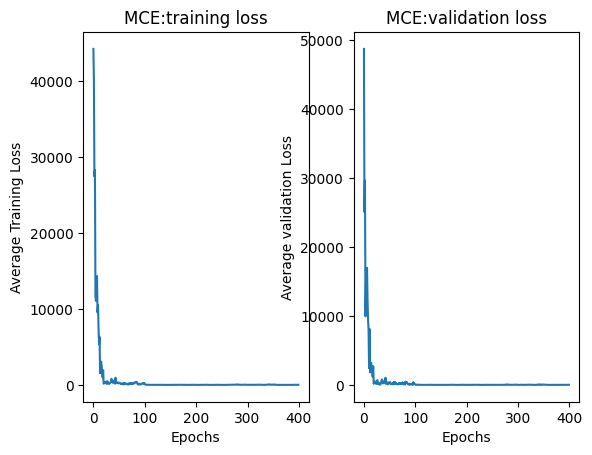

Test Accuracy: 0.5161
Final Test Accuracy: 0.5161


In [28]:
# Create instances of the data
train2 = CustomDatasets(T2_train,labels_T2_train)
valid2 = CustomDatasets(T2_valid, labels_T2_valid)
test2 = CustomDatasets(T2_test, labels_T2_test)

train_loader = DataLoader(train2, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid2, batch_size=200, shuffle=False)
test_loader = DataLoader(test2, batch_size=200, shuffle=False)

set_seed(50)
ff= FFNN_radiomics()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ff.parameters(), lr=1e-2)
epochs = 400
train_loss = []
validation_loss = []
for t in range(epochs):
  losses = train(train_loader, ff, loss_func, optimizer)
  train_loss.append(losses)
  validation_loss.append(validate(valid_loader, ff, loss_func))

# plot the learning curve
epoch_tr_loss = [torch.tensor(epoch_losses).mean().item() for epoch_losses in train_loss]
epoch_va_loss = [torch.tensor(epoch_losses).mean().item() for epoch_losses in validation_loss]
x=range(epochs)
plt.subplot(1,2,1)
plt.plot(x, epoch_tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.title('MCE:training loss')

plt.subplot(1,2,2)
plt.plot(x, epoch_va_loss)
plt.xlabel('Epochs')
plt.ylabel('Average validation Loss')
plt.title ('MCE:validation loss')
plt.show()

# final test accuracy
final_accuracy = test(test_loader, ff, loss_func)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

## Random Forest 

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

### Basic Implementation using Sklean's Random Forest

In [59]:
rf_model = RandomForestClassifier(random_state=42, class_weight = 'balanced')
rf_model.fit(T1_train, labels_T1_train)

predictions_valid = rf_model.predict(T1_valid)
accuracy_valid = accuracy_score(labels_T1_valid, predictions_valid)
print(f"Validation Accuracy: {accuracy_valid}")

predictions_test = rf_model.predict(T1_test)
accuracy_test = accuracy_score(labels_T1_test, predictions_test)
classification_report = classification_report(labels_T1_test, predictions_test)
print(f"Test Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_report)

Validation Accuracy: 0.3870967741935484
Test Accuracy: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.71      0.65        17
           1       0.29      0.33      0.31         6
           2       0.25      0.12      0.17         8

    accuracy                           0.48        31
   macro avg       0.38      0.39      0.37        31
weighted avg       0.45      0.48      0.46        31



### Hyperparameter Search

In [ ]:
rf_tuned_model = RandomForestClassifier(max_depth=3, random_state=42, class_weight='balanced')
rf_tuned_model.fit(T1_train, labels_T1_train)

# Evaluate the tuned model on validation set
predictions_valid = rf_tuned_model.predict(T1_valid)
accuracy_valid = accuracy_score(labels_T1_valid, predictions_valid)
print(f"Validation Accuracy (Tuned): {accuracy_valid}")

# Evaluate the tuned model on test set
predictions_test = rf_tuned_model.predict(T1_test)
accuracy_test = accuracy_score(labels_T1_test, predictions_test)
classification_report_test = classification_report(labels_T1_test, predictions_test)
print(f"Test Accuracy (Tuned): {accuracy_test}")
print("Classification Report (Tuned):\n", classification_report_test)


Validation Accuracy (Tuned): 0.3870967741935484
Test Accuracy (Tuned): 0.5161290322580645
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.40      0.33      0.36         6
           2       0.38      0.38      0.38         8

    accuracy                           0.52        31
   macro avg       0.46      0.45      0.46        31
weighted avg       0.51      0.52      0.51        31



### T2

In [71]:
rf_model = RandomForestClassifier(random_state=42, class_weight = 'balanced')
rf_model.fit(T2_train, labels_T2_train)

predictions_valid = rf_model.predict(T2_valid)
accuracy_valid = accuracy_score(labels_T2_valid, predictions_valid)
print(f"Validation Accuracy: {accuracy_valid}")

predictions_test = rf_model.predict(T2_test)
accuracy_test = accuracy_score(labels_T2_test, predictions_test)
classification_report = classification_report(labels_T2_test, predictions_test)
print(f"Test Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_report)

Validation Accuracy: 0.5806451612903226
Test Accuracy: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62        16
           1       0.33      0.50      0.40         6
           2       0.33      0.22      0.27         9

    accuracy                           0.48        31
   macro avg       0.43      0.45      0.43        31
weighted avg       0.48      0.48      0.48        31



In [74]:
rf_tuned_model = RandomForestClassifier(max_depth=3, random_state=42, class_weight='balanced')
rf_tuned_model.fit(T2_train, labels_T2_train)

# Evaluate the tuned model on validation set
predictions_valid = rf_tuned_model.predict(T2_valid)
accuracy_valid = accuracy_score(labels_T2_valid, predictions_valid)
print(f"Validation Accuracy (Tuned): {accuracy_valid}")

# Evaluate the tuned model on test set
predictions_test = rf_tuned_model.predict(T2_test)
accuracy_test = accuracy_score(labels_T2_test, predictions_test)
classification_report_test = classification_report(labels_T2_test, predictions_test)
print(f"Test Accuracy (Tuned): {accuracy_test}")
print("Classification Report (Tuned):\n", classification_report_test)

Validation Accuracy (Tuned): 0.6129032258064516
Test Accuracy (Tuned): 0.5806451612903226
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        16
           1       0.50      0.33      0.40         6
           2       0.57      0.44      0.50         9

    accuracy                           0.58        31
   macro avg       0.56      0.51      0.52        31
weighted avg       0.57      0.58      0.57        31

